In [ ]:
!pip install yfinance

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
from xgboost import plot_tree

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import yfinance as yf

In [ ]:
start_date = "2017-01-01"
end_date = "2024-01-01"
symbol = "BTC-USD"
data = yf.download(symbol, start=start_date, end=end_date)
data = data[["Open", "High", "Low", "Close", "Volume"]]
df = data.copy()
df.head(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000


In [ ]:
df_fe = df.copy()
df_fe["Range"] = df_fe["High"] / df_fe["Low"] - 1
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

In [ ]:
df_fe.loc[df_fe["Range"].shift(-1) > df_fe["Avg_Range"], "TARGET"] = 1
df_fe.loc[df_fe["Range"].shift(-1) <= df_fe["Avg_Range"], "TARGET"] = 0

In [ ]:
df_fe.dropna(inplace=True)
print(df_fe.isnull().values.any())

False


In [ ]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2526 entries, 2017-01-30 to 2023-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2526 non-null   float64
 1   High       2526 non-null   float64
 2   Low        2526 non-null   float64
 3   Close      2526 non-null   float64
 4   Volume     2526 non-null   int64  
 5   Range      2526 non-null   float64
 6   Avg_Range  2526 non-null   float64
 7   TARGET     2526 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 177.6 KB


# Train Test Split

In [ ]:
df_tts = df_fe.copy()
df_tts.drop(columns=["Close","Open", "High", "Low"], inplace=True)

In [ ]:
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of X_train:  (2020, 3)
Shape of y_train:  (2020,)


# Build Initial Model and Find Hyperparameters

In [ ]:
classifier_0 = XGBClassifier()

In [ ]:
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

In [ ]:
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid)
best_model = grid_search.fit(X_train, y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]
print("Recommended Params >>", f"ne: {ne},", f"lr: {lr}", f"md: {md}", f"gm: {gm}")

Recommended Params >> ne: 80, lr: 0.03 md: 3 gm: 2


# Train Model

In [ ]:
classifier_1 = XGBClassifier(
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [ ]:
classifier_1.fit(
    X_train,
    y_train,
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=80,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

# Make Predictions

In [ ]:
train_predicted = classifier_1.predict(X_train)

In [ ]:
test_predicted = classifier_1.predict(X_test)

In [ ]:
print("Train Accuracy: ", accuracy_score(y_train, train_predicted))
print("Test Accuracy: ", accuracy_score(y_test, test_predicted))

Train Accuracy:  0.6886138613861386
Test Accuracy:  0.642292490118577


In [ ]:
# Summary report - Training
print(classification_report(y_train, train_predicted))

              precision    recall  f1-score   support

         0.0       0.68      0.96      0.80      1280
         1.0       0.76      0.22      0.34       740

    accuracy                           0.69      2020
   macro avg       0.72      0.59      0.57      2020
weighted avg       0.71      0.69      0.63      2020



In [ ]:
# Summary report - Test
print(classification_report(y_test, test_predicted))

              precision    recall  f1-score   support

         0.0       0.64      0.96      0.77       316
         1.0       0.62      0.12      0.20       190

    accuracy                           0.64       506
   macro avg       0.63      0.54      0.49       506
weighted avg       0.64      0.64      0.56       506



#Confusion Matrix



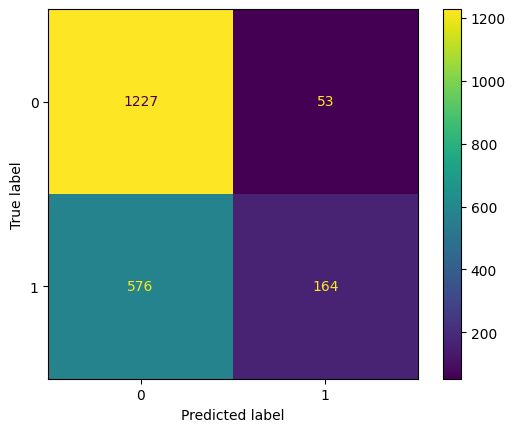

In [ ]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_predicted)
ConfusionMatrixDisplay(cm_train).plot()

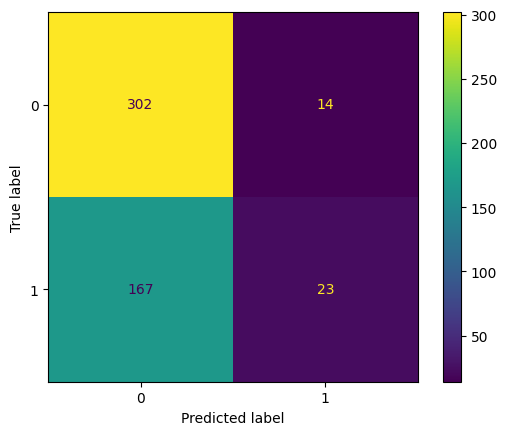

In [ ]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_predicted)
ConfusionMatrixDisplay(cm_test).plot()

# XGBOOST TREE

<Axes: >

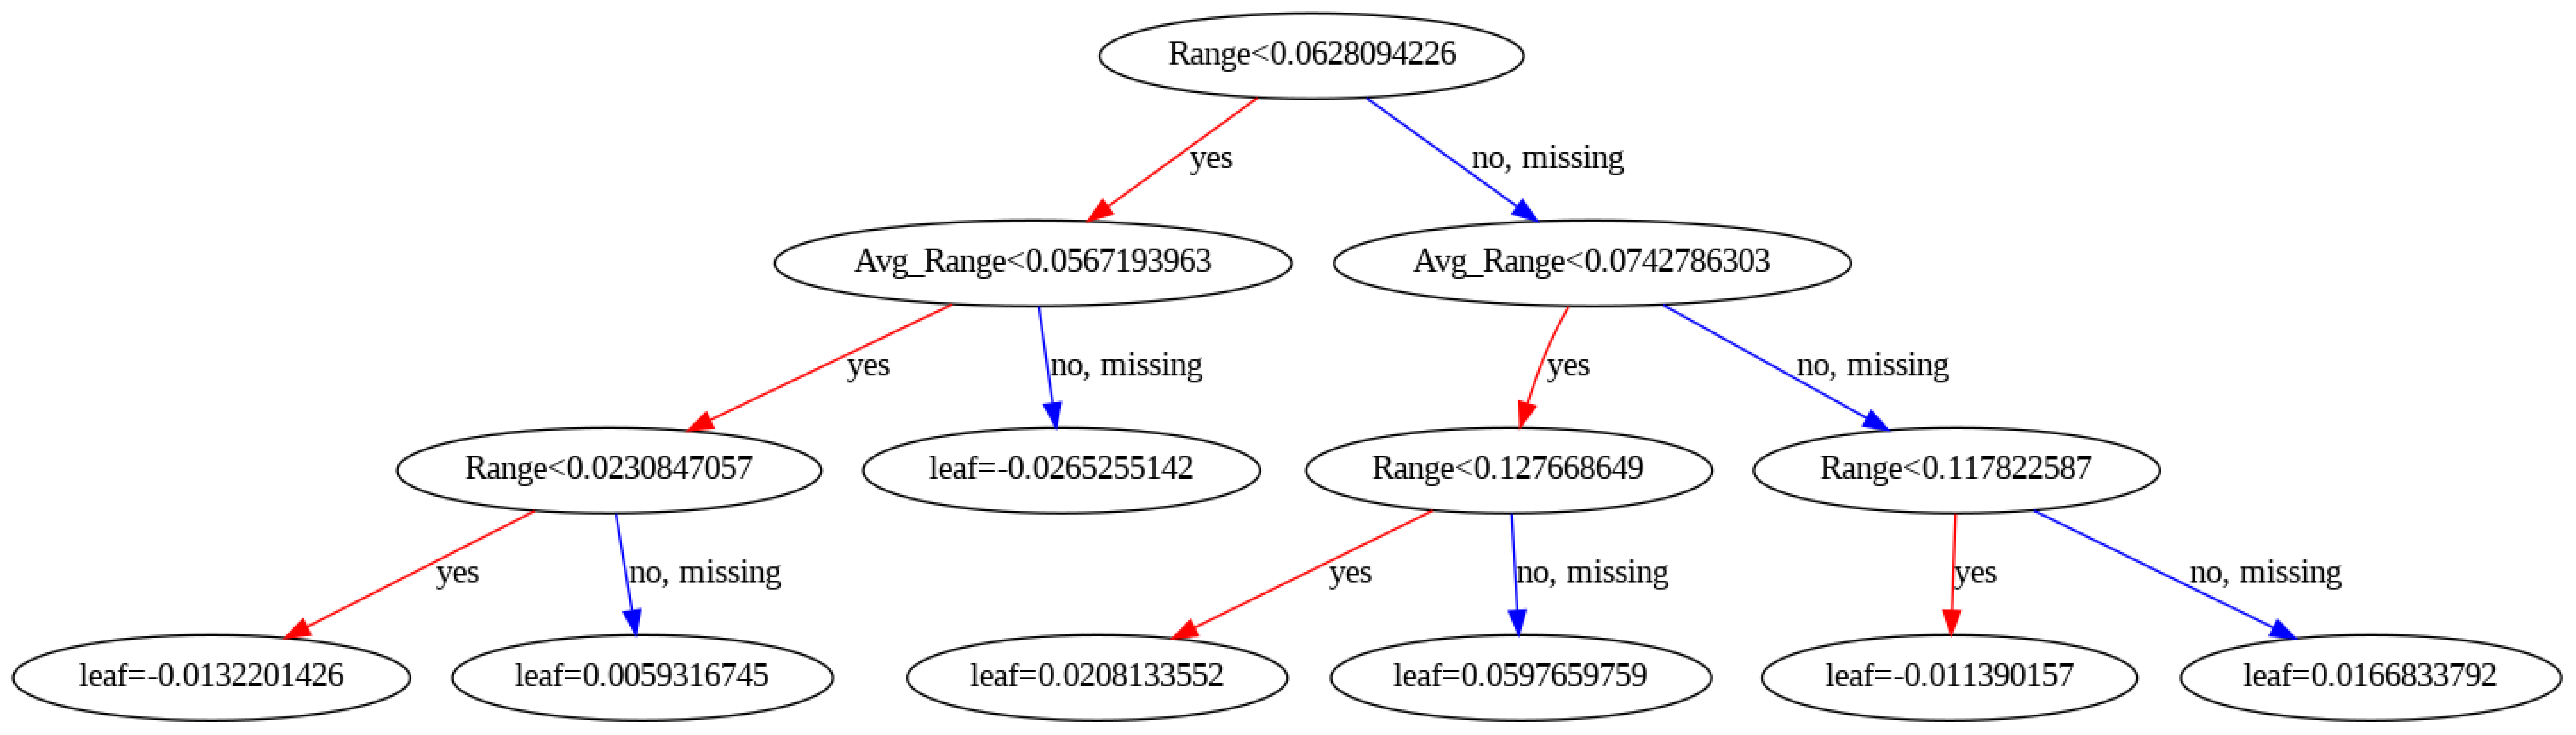

In [ ]:
rcParams["figure.figsize"] = 80, 50
plot_tree(classifier_1)